# INFO 3402 – Class 30: Setting  up a database

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)  

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100

import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

Objectives:

* Setting up a database on Amazon Web Services' free tier
* Using MySQL Workbench to adminster the database
* Using Python/pandas to populate the database
* Perform exploratory queries on the database

## Setting up a database on AWS free tier

I will use Amazon Web Services to demonstrate how to set up a remote database. I will use the "free" tier, which still requires a credit card and free credits stop after 750 hours (~1 month). **If you use AWS or another service's free tier, make _sure_ to stop or delete your database instance before you run out of free credits!**

Tutorial documentation for AWS:
* [Creating a MySQL DB Instance and Connecting to a Database on a MySQL DB Instance](https://docs.aws.amazon.com/en_pv/AmazonRDS/latest/UserGuide/CHAP_GettingStarted.CreatingConnecting.MySQL.html)
* [Connecting to a DB Instance Running the MySQL Database Engine
](https://docs.aws.amazon.com/en_pv/AmazonRDS/latest/UserGuide/USER_ConnectToInstance.html)  

Steps:
1. Create or log into your AWS Management Console: https://console.aws.amazon.com/
2. Search or navigate to "RDS" (Relational Database System)
3. Click "Create database"
4. Select "Standard Create" for creation method, "MySQL" for Engine type, "Free tier" for template, choose your own identifier for "DB instance identifier", enter a password for your database admin account, under Connectivity > Publicly accessible select Yes, and leave everything else as defaults. Click "Create database" and AWS will start spinning up a new database, which should take approximately 5 minutes.
5. Once your database is created, change the network security permissions to allow access from anywhere. (This is a ***gigantic*** security risk that you'd never want to do if you were operating a database with private data, but we have no security concerns about the public data we're using in this class.) Under "Security group rules" click the "default (SG-dbXXXXXX)" link which should pop up a new window. Under the Inbound tab, select "Edit", and make sure "All traffic" under "Type" is selected and "Anywhere" under "Source" is selected. Click save. Repeat for the Outbound tab. 
6. Return to the RDS dashboard, confirm that your database is now "Available" (under Info) and copy the endpoint information. This is also known as the "host" and is the public address of where the database lives. For the Boulder County Assessors Data, this is: `info3402-f19-boulderproperty.cjuyvrfem14z.us-west-2.rds.amazonaws.com`

## Using MySQL Workbench to administer the database

[MySQL Workbench](https://www.mysql.com/products/workbench/) is a graphical interface for managing and querying MySQL databases in lieu of connecting to the database and running commands from a terminal. 

1. After downloading and installing, launch MySQL Workbench. Click the plus sign to enter the "Setup New Connection" window. Name your connection, keep the default "Standard (TCP/IP)" for Connection Method, and under the "Parameters" tab enter the host (*e.g.*, AWS RDS endpoint address) for Hostname, change the Username to "admin", and (if you're using AWS RDS) change Default Schema to "innodb". You'll enter your password later. Close the "Manage Server Connections" window.
2. There should be a new tile in your MySQL Connections. Click it and hopefully you successfully connect to the database. The first time you connect, you will need to enter the admin password you defined when you created the database.
3. Once you connect a new window should open with a "Navigator" window on the left. The different databases available on the server are under "Schemas". Don't mess with the "sys" database. The "innodb" schema is where we are going to put our data. 
4. We generally don't want to use the admin account for querying or inserting data since it can also be used to alter the database in significant ways, including deleting tables, databases, *etc*. Go to the "Users and Privileges", selecct the "Add Account", enter the username for "Login Name", and enter a password and confirm it. Click "Apply". Go to the "Schema Privileges" tab, select "Add Entry...", confirm "All Schema (%)" is selected, and click Ok. Click the new entry, and at a minimum check the boxes for "SELECT", "INSERT", and "UPDATE" under "Object Rights". Click "Apply".  

Now you should have a new account with the privileges to query and insert data into the database. We will use this instead of the admin account to access and query the database.

## Using Python/pandas to populate the database

Make the connection to the database using the new account we created.

In [13]:
from sqlalchemy import create_engine


host = 'info3402-f19-boulderproperty.cjuyvrfem14z.us-west-2.rds.amazonaws.com'
user = 'admin'
port = 3306
password = 'bouldercolorado'
database = 'innodb'

# dialect[+driver]://user:password@host/dbname[?key=value..]
engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}'.format(user,password,host,port,database),
                       pool_size=10,
                       max_overflow=20,
                       connect_args={'connect_timeout': 10000})
conn = engine.connect()

I always test out a simple "show tables" query. This should be empty because we have neither created any tables nor populated them with any data.

In [20]:
pd.read_sql_query('show tables',conn)

,Tables_in_innodb
0,Account_Parcels
1,Assessment
2,Assessments
3,Buildings
4,Business_Personal_Property
5,Land
6,Owner_Address
7,Permits
8,Sales
9,Tax_Areas


We are going to use pandas's [`to_sql`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html) function to populate the database with data. 

I have downloaded the "Owners & Addresses", "Buildings", "Land", "All Sales", "Permits", and "Property Values" CSV files from the [Boulder County Assessor's Office](https://www.bouldercounty.org/property-and-land/assessor/data-download/). You will almost certainly want to heed the advise given on the website as well as review the [documentation PDF](https://assets.bouldercounty.org/wp-content/uploads/2017/02/ar-property-data-download-help.pdf).

This is approximately 200MB of data, not huge but larger than what we've used to date. If you were loading gigabytes or more of data, you would likely want to use something like `LOAD DATA` ([documentation](https://dev.mysql.com/doc/refman/8.0/en/load-data.html), [AWS documentation](https://docs.aws.amazon.com/en_pv/AmazonRDS/latest/UserGuide/MySQL.Procedural.Importing.Other.html)) or `mysqlimport` ([documentation](https://dev.mysql.com/doc/refman/8.0/en/mysqlimport.html), [AWS RDS documentation](https://docs.aws.amazon.com/en_pv/AmazonRDS/latest/UserGuide/MySQL.Procedural.Importing.AnySource.html)) to import the data into your database.

We will do something a bit more indirect but more compatible with how we've been interacting with data so far: use `pandas` to read data into memory and then use `to_sql` to send the data to the database.

In [3]:
# Read in file, your file structure may be different
buildings_df = pd.read_csv('./Boulder Property/Buildings.csv')

# Inspect
print("There are {:,} rows of data.".format(len(buildings_df)))
buildings_df.head()

There are 166,626 rows of data.


/Users/briankeegan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,strap,bld_num,section_num,designCode,designCodeDscr,qualityCode,qualityCodeDscr,bldgClass,bldgClassDscr,ConstCode,ConstCodeDscr,builtYear,CompCode,EffectiveYear,bsmtSF,bsmtType,bsmtTypeDscr,carStorageSF,carStorageType,carStorageTypeDscr,nbrBedRoom,nbrRoomsNobath,mainfloorSF,nbrThreeQtrBaths,nbrFullBaths,nbrHalfBaths,TotalFinishedSF,Ac,AcDscr,Heating,HeatingDscr,ExtWallPrim,ExtWallDscrPrim,ExtWallSec,ExtWallDscrSec,IntWall,IntWallDscr,Roof_Cover,Roof_CoverDscr,Stories,UnitCount,status_cd
0,M2000001,1,1,0320,DOUBLE WIDE,30,AVERAGE,1235,MANUFACTURED HOUSING IMPROVEMENTS,0,NaN,1999,1.0,1999,0,0,0,560,GRC,CARPORT AREA,0.0,0.0,1680,0.0,0.0,0.0,1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
1,M2000002,1,1,0310,SINGLE WIDE,30,AVERAGE,1235,MANUFACTURED HOUSING IMPROVEMENTS,0,NaN,1998,1.0,1998,0,0,0,0,0,0,0.0,0.0,1216,0.0,0.0,0.0,1216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
2,M2000003,1,1,0310,SINGLE WIDE,30,AVERAGE,1235,MANUFACTURED HOUSING IMPROVEMENTS,0,NaN,1999,1.0,1999,0,0,0,0,0,0,0.0,0.0,928,0.0,0.0,0.0,928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
3,M2000004,1,1,0320,DOUBLE WIDE,30,AVERAGE,1235,MANUFACTURED HOUSING IMPROVEMENTS,0,NaN,1998,1.0,1998,0,0,0,0,0,0,0.0,0.0,1232,0.0,0.0,0.0,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
4,M2000007,1,1,0320,DOUBLE WIDE,30,AVERAGE,1235,MANUFACTURED HOUSING IMPROVEMENTS,0,NaN,2000,1.0,2000,0,0,0,0,0,0,0.0,0.0,1248,0.0,0.0,0.0,1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A


Now we can use `to_sql` to send this data to the database. This could take a few minutes to send all the data. While you wait, you can go back to the AWS console and look under the "Monitoring" tab to see the spike in "Write IOPS".

In [14]:
buildings_df.to_sql(name='Buildings',       # Name of the table in the database we're creating/overwriting
                    con=conn,               # Connection to use
                    if_exists='replace',    # If the table already exists, replace all the data in it 
                    index=False,            # Don't include the DataFrame index
                    chunksize=10000)        # Write 10,000 rows at a time

There should now be a a "Buildings" table in the innodb schema. You can check this with the show tables query or in MySQL Workbench.

In [18]:
pd.read_sql_query('show tables',conn)

OperationalError: (pymysql.err.OperationalError) (2013, 'Lost connection to MySQL server during query')
[SQL: show tables]
(Background on this error at: http://sqlalche.me/e/e3q8)

Double check it has the same number as rows as the file in memory.

In [15]:
pd.read_sql_query('SELECT COUNT(*) FROM Buildings',conn)

,COUNT(*)
0,166626


To read in the other files, I will write a loop. 

First, I need a list of all the tables currently in the database. This is basically the query above with the values under the "Tables_in_innodb" converted to a list.

In [9]:
db_tables = pd.read_sql_query('show tables',conn)['Tables_in_innodb'].tolist()
db_tables

['Buildings']

Next, I need a list of all the CSV files I want to upload. **NOTE: I changed the filename "Values.csv" to "Assessments.csv" because Values is a special MySQL function which can create confusion.**

In [10]:
# Get all the filenames in a directory
files = os.listdir('./Boulder Property/')

# Filter to only those that contain ".csv"
csv_files = [f for f in files if '.csv' in f]

csv_files

['Permits.csv',
 'Owner_Address.csv',
 'Land.csv',
 'Buildings.csv',
 'Assessments.csv',
 'Sales.csv']

Because I want each of these files to have the same table name without the CSV, do some basic string manipulation.

In [11]:
csv_files[0].split('.csv')[0]

'Permits'

In [12]:
# or
csv_files[0][:-4]

'Permits'

Put all the pieces together.

In [13]:
# Get a list of all the tables currently in the database
db_tables = pd.read_sql_query('show tables',conn)['Tables_in_innodb'].tolist()

# Loop through each of the CSV filenames
for f in csv_files:
    
    # Strip off the ".csv" part of the filename
    table_name = f.split('.csv')[0]
    
    # Don't reupload tables (like Buildings) we've already uploaded
    if table_name not in db_tables:
        
        # Load the file into memory
        _df = pd.read_csv('./Boulder Property/' + f)
        
        # Do some exception handling so we can walk away for a few minutes while things (hopefully!) upload
        try:
            
            # Insert the data into the database using .to_sql
            _df.to_sql(name = table_name, # Use the table name here
                       con = conn,
                       if_exists = 'replace',
                       index = False,
                       chunksize = 10000)
            
        except:
            # If something breaks, print the table name
            print(table_name)
            
            # And move on to the next file
            pass

/Users/briankeegan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Double-check all the tables are in there.

In [15]:
pd.read_sql_query('show tables',conn)

,Tables_in_innodb
0,Assessments
1,Buildings
2,Land
3,Owner_Address
4,Permits
5,Sales


## Perform exploratory queries on the database

I always start with a few rows of data from each table just to get a sense for columns, data types, *etc*.

In [16]:
q = """
SELECT
    *
FROM
    Assessments
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,strap,tax_yr,bldAcutalVal,LandAcutalVal,xfActualVal,totalActualVal,landAssessedVal,bldAssessedVal,xfAssessedVal,totalAssessedVal,status_cd
0,M2000001,2019,77100,0,None,77100,None,5513.0,None,5513,A
1,M2000002,2019,46700,0,None,46700,None,3339.0,None,3339,A
2,M2000003,2019,33000,0,None,33000,None,2360.0,None,2360,A
3,M2000004,2019,55600,0,None,55600,None,3975.0,None,3975,A
4,M2000007,2019,58600,0,None,58600,None,4190.0,None,4190,A


In [14]:
q = """
SELECT
    *
FROM
    Buildings
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,strap,bld_num,section_num,designCode,designCodeDscr,qualityCode,qualityCodeDscr,bldgClass,bldgClassDscr,ConstCode,ConstCodeDscr,builtYear,CompCode,EffectiveYear,bsmtSF,bsmtType,bsmtTypeDscr,carStorageSF,carStorageType,carStorageTypeDscr,nbrBedRoom,nbrRoomsNobath,mainfloorSF,nbrThreeQtrBaths,nbrFullBaths,nbrHalfBaths,TotalFinishedSF,Ac,AcDscr,Heating,HeatingDscr,ExtWallPrim,ExtWallDscrPrim,ExtWallSec,ExtWallDscrSec,IntWall,IntWallDscr,Roof_Cover,Roof_CoverDscr,Stories,UnitCount,status_cd


In [18]:
q = """
SELECT
    *
FROM
    Land
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,strap,landUnitValue,landUnitType,landClass,landClassDscr,GIS_sqft,GIS_acreage,status_cd
0,R0000002,1.0,UT,1230.0,CONDO LAND NEW METHOD,0,0.000,A
1,R0000003,1.0,UT,1230.0,CONDO LAND NEW METHOD,0,0.000,A
2,R0000005,7958.0,SF,1112.0,SINGLE FAM.RES.-LAND,7958,0.183,A
3,R0000006,8995.0,SF,1112.0,SINGLE FAM.RES.-LAND,8995,0.206,A
4,R0000007,6185.0,SF,1112.0,SINGLE FAM.RES.-LAND,6185,0.142,A


In [19]:
q = """
SELECT
    *
FROM
    Owner_Address
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,CreatedDate,strap,folio,status_cd,bld_num,str_num,str,str_pfx,str_sfx,str_unit,city,sub_code,sub_dscr,section,township,range,block,lot,owner_name,mail_to,mailingAddr1,mailingAddr2,mailingCity,mailingState,mailingZip,mailingCountry,role_cd,pct_own,taxArea,nh,mill_levy,legalDscr,waterFee,account_type
0,11/3/2019 4:01:09 AM,M2000001,146318113001,A,0.0,4500.0,19TH,None,ST,119,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,BRETADO-SEGOVIA NORATO SERGIO,None,4500 19TH ST #119,None,BOULDER,CO,80304,None,P,1.0,10,122.0,86.7,119 COUNTRYSIDE VILLAGE BO MHP 99 LEX 60X28 2T...,None,MANUFACTURED HOME
1,11/3/2019 4:01:09 AM,M2000002,146318113001,A,0.0,4500.0,19TH,None,ST,113,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,LASTIRI BENJAMIN,None,4500 19TH ST 113,None,BOULDER,CO,80304,None,P,1.0,10,122.0,86.7,113 COUNTRYSIDE VILLAGE BO MHP 98 PRE 76X16 GD...,None,MANUFACTURED HOME
2,11/3/2019 4:01:09 AM,M2000003,146321300001,A,0.0,5000.0,BUTTE,None,ST,185,BOULDER,8464.0,VISTA VILLAGE - MHP BOV,21.0,1N,70.0,,,KRAUSE CLARINDA L,None,5000 BUTTE ST 185,None,BOULDER,CO,80301,None,P,1.0,10,135.0,86.7,185 VISTA VILLAGE MHP 99 CHA 58X16 4990 229934...,None,MANUFACTURED HOME
3,11/3/2019 4:01:09 AM,M2000004,146318113001,A,0.0,4500.0,19TH,None,ST,257,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,COUNTRYSIDE VILLAGE ASSOCIATES,C/O BOULDER MEADOWS,280 DAINES ST UNIT 300,None,BIRMINGHAM,MI,48009,None,P,1.0,10,122.0,86.7,257 COUNTRYSIDE VILLAGE BO MHP 99 SKYLINE 44X2...,None,MANUFACTURED HOME
4,11/3/2019 4:01:09 AM,M2000007,146318113001,A,0.0,4500.0,19TH,None,ST,214,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,LOPEZ ABRAHAM & ISABEL ARGUMEDO,None,4500 19TH ST # 214,None,BOULDER,CO,80304,None,P,1.0,10,122.0,86.7,214 COUNTRYSIDE VILLAGE BO MHP AKA BOULDER MEA...,None,MANUFACTURED HOME


In [20]:
q = """
SELECT
    *
FROM
    Permits
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,strap,issued_by,permit_num,permit_category,issue_dt,estimated_value,description
0,M2000001,LONGMONT,200500119,OTHER,1/14/2005 12:00:00 AM,1200.0,None
1,M2000001,LONGMONT,2402,OTHER,7/1/2004 12:00:00 AM,400.0,None
2,M2000001,BOULDER,PMT2015-02334,RESIDENTIAL RE-ROOF,6/16/2015 12:00:00 AM,9600.0,TOTAL TEAR-OFF AND REROOF WITH ASPHALT SHINGLE...
3,M2000001,BOULDER,PMT2015-02461,RESIDENTIAL RE-ROOF,6/23/2015 12:00:00 AM,9600.0,TOTAL TEAR-OFF AND REROOF WITH ASPHALT SHINGLE...
4,M2000008,LOUISVILLE,MISC-1726-2018,RESIDENTIAL RE-ROOF,7/24/2018 12:00:00 AM,9000.0,REROOF


In [21]:
q = """
SELECT
    *
FROM
    Sales
LIMIT
    5
"""

pd.read_sql_query(q,conn)

,strap,deedNum,Tdate,sales_cd,deed_type,price,status_cd
0,M2000001,7P193092,9/13/1999 12:00:00 AM,Q,TN,66000.0,A
1,M2000001,7P544958,9/13/1999 12:00:00 AM,P,NC,0.0,A
2,M2000001,3616937,9/27/2017 12:00:00 AM,Q,VT,95000.0,A
3,M2000002,7P197496,10/13/1999 12:00:00 AM,Q,TN,50900.0,A
4,M2000002,3157017,1/15/2010 12:00:00 AM,Q,VT,30000.0,A


How many years of data are in the Assessments table? Well, that's disappointing there's no historical data (e-mail me if you want it though).

In [22]:
q = """
SELECT
    DISTINCT(tax_yr)
FROM
    Assessments
"""

pd.read_sql_query(q,conn)

,tax_yr
0,2019


What's the distribution of years when buildings were constructed?

In [23]:
q = """
SELECT
    builtYear, COUNT(builtYear) as count
FROM
    Buildings
GROUP BY
    builtYear
ORDER BY
    builtYear DESC
"""

built_year_df = pd.read_sql_query(q,conn)
built_year_df.tail(10)

,builtYear,count
149,1867,5
150,1866,2
151,1865,9
152,1864,2
153,1863,2
154,1862,13
155,1860,5
156,1858,1
157,5,1
158,0,207


Looks like there are some wacky values in there, so let's add an additional filter.

In [24]:
q = """
SELECT
    builtYear, COUNT(builtYear) as count
FROM
    Buildings
GROUP BY
    builtYear
HAVING
    builtYear > 1850
ORDER BY
    builtYear DESC
"""

built_year_df = pd.read_sql_query(q,conn)
built_year_df.tail(10)

,builtYear,count
147,1871,10
148,1870,22
149,1867,5
150,1866,2
151,1865,9
152,1864,2
153,1863,2
154,1862,13
155,1860,5
156,1858,1


How many different kinds of permits have been issued?

In [25]:
q = """
SELECT
    permit_category, COUNT(permit_category) as count
FROM
    Permits
GROUP BY
    permit_category
ORDER BY
    count DESC
LIMIT
    10
"""

pd.read_sql_query(q,conn)

,permit_category,count
0,RESIDENTIAL RE-ROOF,41538
1,NEW CONSTRUCTION,14459
2,REMODEL,14217
3,OTHER,12589
4,AIR CONDITIONER,9677
5,ENERGY EFFICIENT SYSTEM,8425
6,HEATING SYSTEM,7927
7,BASEMENT FINISH,7926
8,WINDOWS OR DOORS,7404
9,ADDITION,5987


How well do the Building table's "builtYear" and Permit table's "NEW CONSTRUCTION" values line up? The datetimes were interpreted as strings when we read them in and inserted them, but MySQL can still treat them like datetimes with the [STR_TO_DATE](https://www.w3schools.com/sql/func_mysql_str_to_date.asp) function and a number of other powerful [Date and Time Functions](https://dev.mysql.com/doc/refman/5.5/en/date-and-time-functions.html). If we went back and read in the CSVs, parsed the datetime columns to datetimes, and then used `.to_sql` to insert, this would save us some headaches down the road.

In [26]:
q = """
SELECT
    YEAR(STR_TO_DATE(issue_dt,'%%m/%%d/%%Y')) as year, COUNT(permit_category) as count
FROM
    Permits
WHERE
    permit_category = 'NEW CONSTRUCTION'
    AND YEAR(STR_TO_DATE(issue_dt,'%%m/%%d/%%Y')) < 2019
    AND YEAR(STR_TO_DATE(issue_dt,'%%m/%%d/%%Y')) > 1850
GROUP BY
    year
ORDER BY
    year DESC
"""

annual_permits_df = pd.read_sql_query(q,conn)
annual_permits_df

/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect date value: '4/27/2009 12:00:00 AM'")
  result = self._query(query)
/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect date value: '10/10/2016 12:00:00 AM'")
  result = self._query(query)
/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect date value: '5/18/2018 12:00:00 AM'")
  result = self._query(query)
/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect date value: '2/1/2001 12:00:00 AM'")
  result = self._query(query)
/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1292, "Truncated incorrect date value: '9/25/2001 12:00:00 AM'")
  result = self._query(query)
/Users/briankeegan/anaconda3/lib/python3.7/site-packages/pymysql/curso

,year,count
0,2018,1392
1,2017,1265
2,2016,1014
3,2015,981
4,2014,951
5,2013,808
6,2012,595
7,2011,481
8,2010,404
9,2009,245


Plot out the building years and building permit years. The Buildings data has a lot more coverage and more activity even where there is coverage!

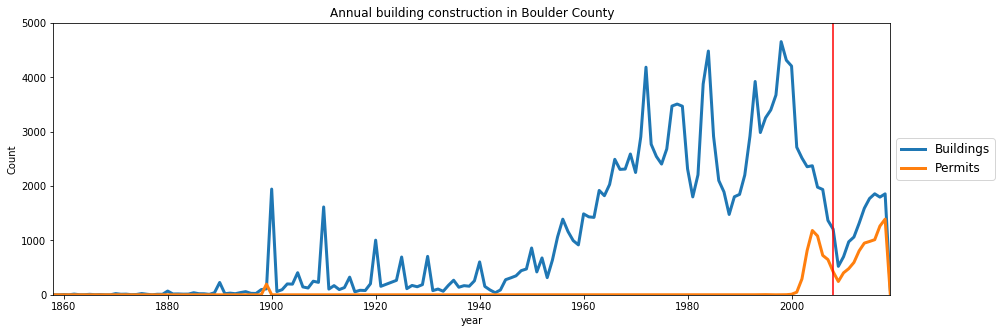

In [28]:
# Set year as index
built_year_count = built_year_df.set_index('builtYear')['count']
# Reindex to be continuous from 1858 to present
built_year_count = built_year_count.reindex(range(1858,2020),fill_value=0)

# Set year as index
annual_permits_count = annual_permits_df.set_index('year')['count']
# Reindex to be continuous from 1858 to present
annual_permits_count = annual_permits_count.reindex(range(1858,2020),fill_value=0)

# Plot
ax = built_year_count.plot(figsize=(15,5),label='Buildings',lw=3)
annual_permits_count.plot(ax=ax,label='Permits',lw=3)

# Add legend and other decorators
ax.legend(loc='center left',bbox_to_anchor=(1,.5),fontsize=12)
ax.set_ylim((0,5000))
ax.set_ylabel('Count')
ax.set_title('Annual building construction in Boulder County')
ax.axvline(2008,color='r')

In [30]:
q = """
SELECT
    *
FROM
    Owner_Address
LIMIT
    2
"""

pd.read_sql_query(q,conn)

,CreatedDate,strap,folio,status_cd,bld_num,str_num,str,str_pfx,str_sfx,str_unit,city,sub_code,sub_dscr,section,township,range,block,lot,owner_name,mail_to,mailingAddr1,mailingAddr2,mailingCity,mailingState,mailingZip,mailingCountry,role_cd,pct_own,taxArea,nh,mill_levy,legalDscr,waterFee,account_type
0,11/3/2019 4:01:09 AM,M2000001,146318113001,A,0.0,4500.0,19TH,None,ST,119,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,BRETADO-SEGOVIA NORATO SERGIO,None,4500 19TH ST #119,None,BOULDER,CO,80304,None,P,1.0,10,122.0,86.7,119 COUNTRYSIDE VILLAGE BO MHP 99 LEX 60X28 2T...,None,MANUFACTURED HOME
1,11/3/2019 4:01:09 AM,M2000002,146318113001,A,0.0,4500.0,19TH,None,ST,113,BOULDER,1841.0,COUNTRYSIDE VILLAGE BOULDER - MHP BOV,18.0,1N,70.0,,,LASTIRI BENJAMIN,None,4500 19TH ST 113,None,BOULDER,CO,80304,None,P,1.0,10,122.0,86.7,113 COUNTRYSIDE VILLAGE BO MHP 98 PRE 76X16 GD...,None,MANUFACTURED HOME


In [34]:
q = """
SELECT
    mailingState, count(mailingState) as count
FROM
    Owner_Address
WHERE
    mailingState != "CO"
GROUP BY
    mailingState
ORDER BY
    count DESC
"""

pd.read_sql_query(q,conn)

,mailingState,count
0,CA,1814
1,TX,982
2,FL,606
3,AZ,523
4,DC,338
5,NY,283
6,WA,275
7,IL,248
8,PA,234
9,MI,206


In [37]:
q = """
SELECT
    *
FROM
    Owner_Address
WHERE
    mailingState = "DC"
"""

dc_owners = pd.read_sql_query(q,conn)

In [39]:
dc_owners['owner_name'].value_counts()

U S GOVERNMENT                           259
UNITED STATES OF AMERICA                  21
ISSA JAMES J                               6
US GOVERNMENT                              5
BARTLETT JANISZEWSKI KATHERINE ET AL       2
BARTLETT JOHN ERIKSEN ET AL                2
SCHILLER CRAIG & GEORGE & JOAN             2
LAYTON TERRY J                             2
KELLEY GAIL S                              2
US SECRETARY OF HOUSING & URBAN DEV        2
USDA FOREST SERVICE                        2
HERRICK FAMILY CABIN LLC                   1
ISENHART JILL B & FRANK R ET AL            1
844 MAIN ST ASSOCIATES LLC                 1
LAYTON TERRY JEAN                          1
GORE VIKAS M & NIRMALA S PURUSHOTAM        1
SCHILLER CRAIG                             1
WILSON ROBERT R                            1
CLARK BARRY TRUST                          1
ANTHONY AUBRA & PAUL KUNZ                  1
UNITED STATES GOVERNMENT                   1
HAGGIN CLAIRE R ET AL                      1
WILLIAMS S